In [1]:

#This is Machine Learning
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import pathlib
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
import keras.utils as image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#This is used to import the data
import glob
import os
from os import listdir
import requests
from zipfile import ZipFile

# Potato
import random
random.seed(0)

# small visulization
from IPython.display import display, Image

2023-12-05 18:01:48.153472: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Stole this from homework 8
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """
    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

Data Importing

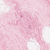

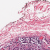

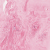

In [3]:
#Got this from ChatGPT

# Define the GitHub repository URL
repo_url = 'https://github.com/StevenHPatrick/breastCancerData/archive/94de9300f0851b14430654cd36089af864e6017b.zip'

# Specify the local path to save the downloaded file
zip_file_path = 'breast_cancer_data.zip'

# Specify the target directory
output_dir = 'breast_cancer_data'

# Check if the target directory already exists
if not os.path.exists(output_dir):
    # Download the dataset from GitHub
    response = requests.get(repo_url)
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)

    # Extract the contents of the ZIP file
    extracted_path = 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b'
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    # Adjust the path to include the additional subdirectory
    dataset_path = os.path.join(extracted_path, 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b')

    # Create the 'breast_cancer_data' directory
    os.makedirs(output_dir)

    # Move the contents to 'breast_cancer_data' directory
    for item in os.listdir(dataset_path):
        s = os.path.join(dataset_path, item)
        d = os.path.join(output_dir, item)
        os.rename(s, d)

# Now, breast_img will contain the paths to the images in 'breast_cancer_data'
breast_img = glob.glob(os.path.join(output_dir, 'archive/IDC_regular_ps50_idx5/**/*.png'), recursive=True)

# Display the first 3 images
for img_path in breast_img[:3]:
    display(Image(filename=img_path))


In [4]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)

    elif img[-5] == '1' :
        can_img.append(img)
breast_img[0]

'breast_cancer_data/archive/IDC_regular_ps50_idx5/9254/0/9254_idx5_x901_y701_class0.png'

Data Discovery

In [5]:
patients = [len(non_img), len(can_img)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients' .format(patients[0]))
print('Number of malignant patients' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients
Number of malignant patients
Total Number of Images : 277524


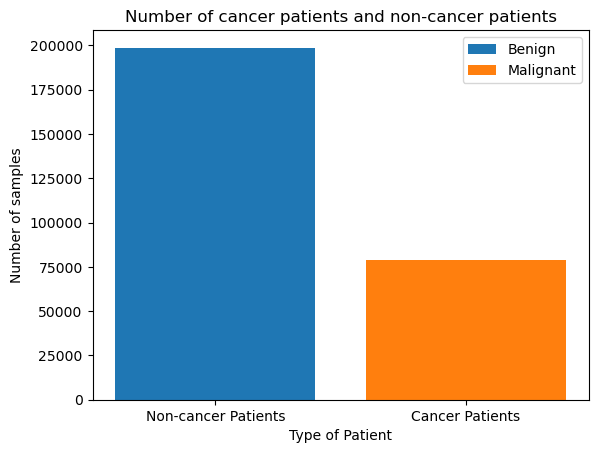

In [6]:
#Written by Steven and only Steven
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

277534 images is a lot to train on. We decided to reduce the number of images we are training on.

In [7]:
non_img = np.array(non_img)
can_img = np.array(can_img)

# Generate random indices
fivek_no_cancer_indices = np.random.randint(0, len(non_img), 5000)
fivek_cancer_indices = np.random.randint(0, len(can_img), 5000)

# Use boolean indexing to copy the selected images
fivek_no_cancer = non_img[fivek_no_cancer_indices]
fivek_cancer = can_img[fivek_cancer_indices]

In [8]:
patients = [len(fivek_no_cancer), len(fivek_cancer)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients' .format(patients[0]))
print('Number of malignant patients' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients
Number of malignant patients
Total Number of Images : 10000


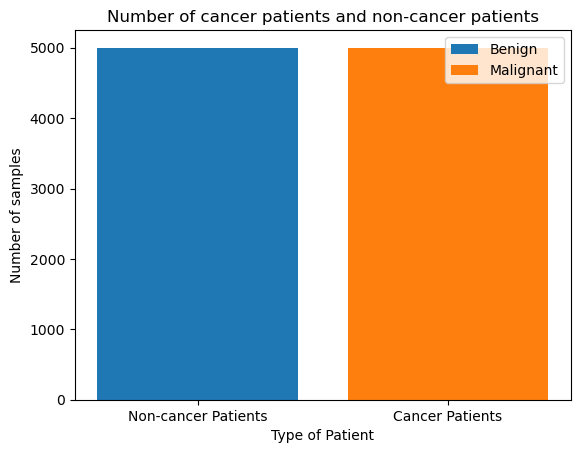

In [9]:
#Written by Steven and only Steven
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

This is a more managable size to start training on. We will look at increasing the dataset later one.

In [10]:
total_img_num = len(fivek_no_cancer) + len(fivek_cancer)

print('Number of Images of no cancer: {}' .format(len(fivek_no_cancer)))   # images of Non cancer
print('Number of Images of cancer : {}' .format(len(fivek_cancer)))   # images of cancer
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 5000
Number of Images of cancer : 5000
Total Number of Images : 10000


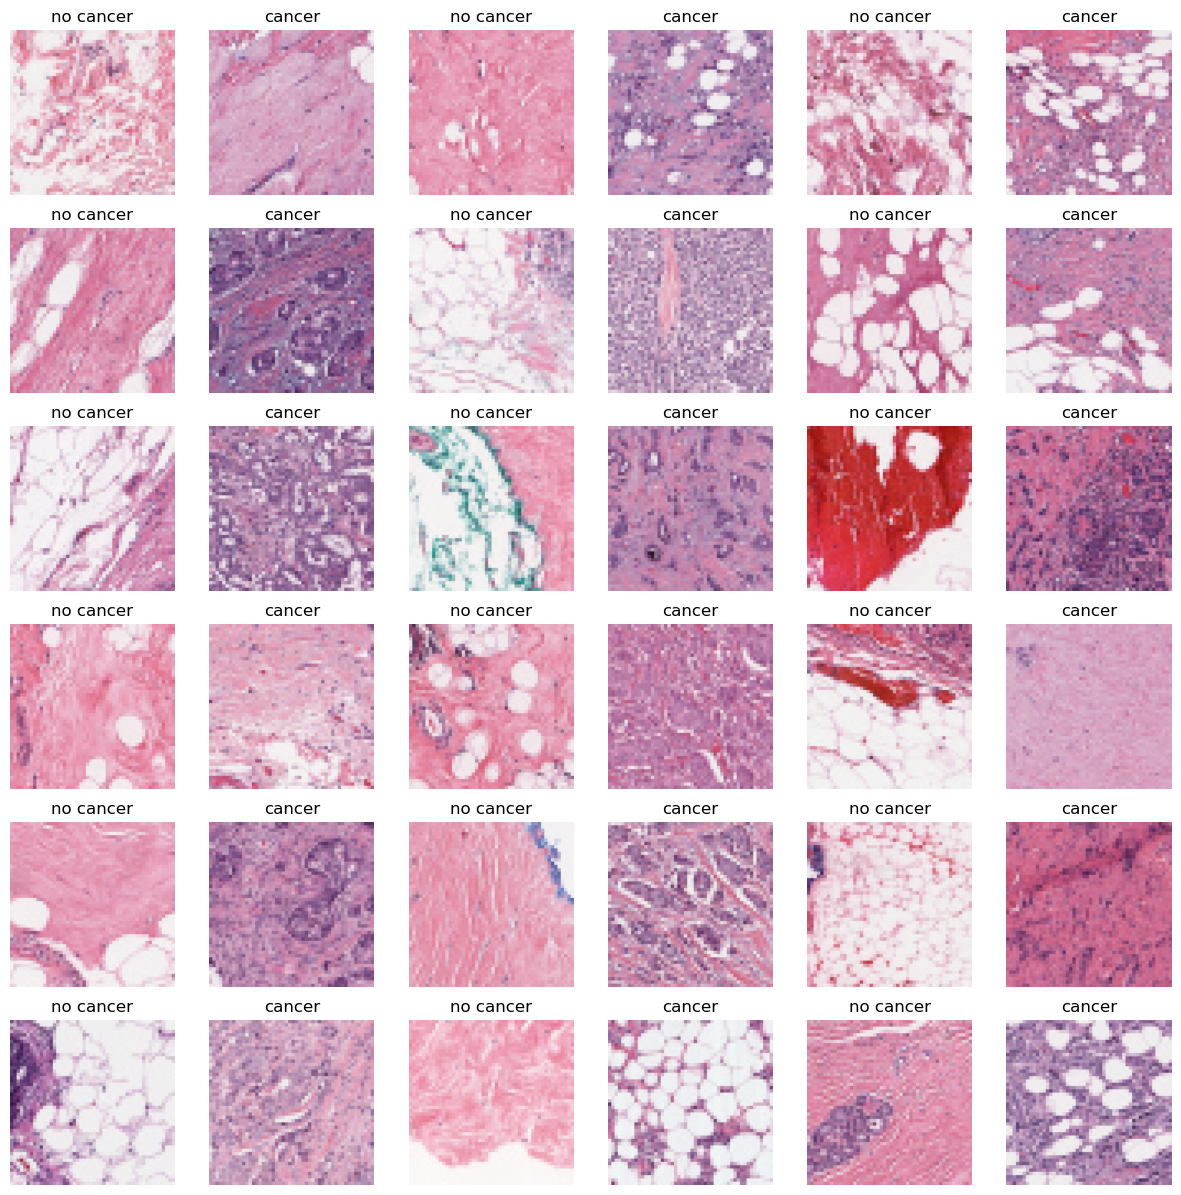

In [11]:
#Took this code from a kaggle notebook because it looked too cool. Also, it confirms that 

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(fivek_no_cancer), 18)
some_can = np.random.randint(0, len(fivek_cancer), 18)

s = 0
for num in some_non:
    
        img = image.load_img((fivek_no_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:
    
        img = image.load_img((fivek_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
plt.show()


In [12]:
def preprocess_images(image_paths, target_size=(100, 100)):
    """Normalize and resize images"""
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1]
        images.append(img_array)
    return np.array(images)

In [13]:
# Load and preprocess "no cancer" images
fivek_no_cancer_images = preprocess_images(fivek_no_cancer)

# Load and preprocess "cancer" images
fivek_cancer_images = preprocess_images(fivek_cancer)

# Combine the datasets
X = np.concatenate([fivek_no_cancer_images, fivek_cancer_images])

# Create labels for the dataset (0 for no cancer, 1 for cancer)
y = np.concatenate([np.zeros(len(fivek_no_cancer_images)), np.ones(len(fivek_cancer_images))])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 100, 100, 3)
X_test shape: (2000, 100, 100, 3)
y_train shape: (8000,)
y_test shape: (2000,)


In [ ]:
# Input layer
input_layer = layers.Input(shape=(100, 100, 3))

# Convolutional layers
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = layers.MaxPooling2D((2, 2))(conv3)

# Flatten the output
flatten = layers.Flatten()(pool3)

# Dense layers
dense1 = layers.Dense(128, activation='relu')(flatten)
dropout = layers.Dropout(0.5)(dense1)  # Dropout layer to reduce overfitting
output_layer = layers.Dense(1, activation='sigmoid')(dropout)  # Output layer with sigmoid activation for binary classification

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training history
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856 

2023-12-05 18:01:55.330375: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
250/250 [==============================] - 41s 163ms/step - loss: 0.5923 - accuracy: 0.6920 - val_loss: 0.4814 - val_accuracy: 0.7910
Epoch 2/50
250/250 [==============================] - 40s 158ms/step - loss: 0.4911 - accuracy: 0.7857 - val_loss: 0.4910 - val_accuracy: 0.7700
Epoch 3/50
250/250 [==============================] - 40s 159ms/step - loss: 0.4735 - accuracy: 0.7906 - val_loss: 0.4180 - val_accuracy: 0.8135
Epoch 4/50
250/250 [==============================] - 40s 160ms/step - loss: 0.4699 - accuracy: 0.7891 - val_loss: 0.4476 - val_accuracy: 0.8035
Epoch 5/50
250/250 [==============================] - 39s 155ms/step - loss: 0.4522 - accuracy: 0.8067 - val_loss: 0.4499 - val_accuracy: 0.7970
Epoch 6/50
152/250 [=================>............] - ETA: 14s - loss: 0.4956 - accuracy: 0.7926